In [ ]:
%%capture
!pip install transformers
!pip install nltk==3.5
!pip install rouge

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

In [ ]:
import torch
import numpy as np
import pandas as pd
from rouge import Rouge
from transformers import pipeline
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import re
#from nltk.translate.bleu_score import SmoothingFunction
#from nltk.translate.meteor_score import single_meteor_score

In [ ]:
# Load data
path = '/content/drive/MyDrive/AML_workshop/'
filename = 'hot_topics_data_100K.csv'

df = pd.read_csv(path + filename, nrows = 2000)
df.columns = ['id', 'FINDINGS', 'IMPRESSION']
df.shape # (100000, 3)

(2000, 3)

In [ ]:
finding_len = [len(x.split()) for x in df['FINDINGS']]
impression_len = [len(x.split()) for x in df['IMPRESSION']]

print(np.percentile(finding_len, [85, 90, 95]))
print(np.percentile(impression_len, [85, 90, 95]))
print(np.percentile(impression_len, [5, 10, 15]))

[193.  221.  268.1]
[45.  56.1 71. ]
[3. 5. 6.]


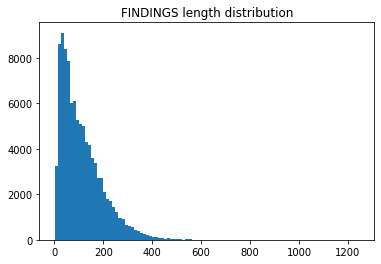

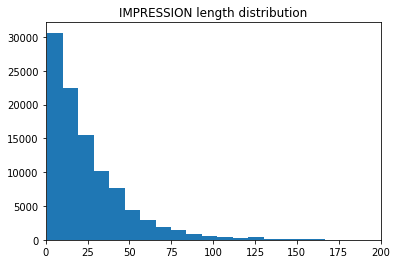

In [ ]:
plt.figure()
plt.hist(finding_len, bins = 100)
plt.title("FINDINGS length distribution")
plt.show()

plt.figure()
plt.hist(impression_len, bins = 100)
plt.title("IMPRESSION length distribution")
plt.xlim((0,200))
plt.show()

# BART

In [ ]:
# Load data
path = '/content/drive/MyDrive/AML_workshop/'
filename = 'test_set_2000.csv'
df = pd.read_csv(path + filename)
df.shape # (100000, 3)
"""
filename = 'hot_topics_data_100K.csv'  # 6% duplicates
df = pd.read_csv(path + filename)
del df['Unnamed: 0']
df = df.drop_duplicates(['FINDINGS', 'IMPRESSION']).head(2000)
df.reset_index(inplace = True)
df.columns = ['index', 'FINDINGS', 'IMPRESSION']
"""

"\nfilename = 'hot_topics_data_100K.csv'  # 6% duplicates\ndf = pd.read_csv(path + filename)\ndel df['Unnamed: 0']\ndf = df.drop_duplicates(['FINDINGS', 'IMPRESSION']).head(2000)\ndf.reset_index(inplace = True)\ndf.columns = ['index', 'FINDINGS', 'IMPRESSION']\n"

In [ ]:
# Evaluation

def sentence_bleu_n(x, weights):
  regex = re.compile('[^a-zA-Z]')
  #chencherry = SmoothingFunction()
  return sentence_bleu(references = [regex.sub(' ', x[1]).strip().split()], 
                            hypothesis = regex.sub(' ', x[0]).strip().split(),
                            weights = weights)

def nlp_evaluate(df):

  data = df.copy()

  # bleu
  data['bleu1'] = data[['pred', 'IMPRESSION']].apply(lambda x: sentence_bleu_n(x, [1,0,0,0]), axis=1)
  data['bleu2'] = data[['pred', 'IMPRESSION']].apply(lambda x: sentence_bleu_n(x, [0.5,0.5,0,0]), axis=1)
  data['bleu3'] = data[['pred', 'IMPRESSION']].apply(lambda x: sentence_bleu_n(x, [0.33,0.33,0.33,0]), axis=1)
  data['bleu4'] = data[['pred', 'IMPRESSION']].apply(lambda x: sentence_bleu_n(x, [0.25,0.25,0.25,0.25]), axis=1)

  # rogue
  rouge = Rouge()
  rogue_list = data[['pred', 'IMPRESSION']].apply(lambda x: rouge.get_scores(hyps = x[0], refs = x[1], avg = False)[0], axis = 1)
  rogue_df = pd.json_normalize(rogue_list)
  data = pd.concat([data, rogue_df], axis = 1)

  return data


In [ ]:
def chunks(df, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield df.iloc[i:i + n,:]

In [ ]:
impression_max_len = 54
#impression_min_len = 5

In [ ]:
# Load pre-trained models
summarizer = pipeline("summarization", model='facebook/bart-large-cnn', tokenizer='facebook/bart-large-cnn')

In [ ]:
def get_summary(x):
  try:
    return summarizer(x, 
                      max_length=impression_max_len,
                      do_sample = False)[0]['summary_text']
  except:
    return None

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_name = 'BART_pred_eval_1105.csv'
n = 50
pd.DataFrame(columns = ['id', 'FINDINGS', 'IMPRESSION', 'pred']).to_csv(path + file_name, index = False)

In [ ]:
for i in range(50, df.shape[0], n):
  df_subset = df.iloc[i:i+n, :]
  df_subset['pred'] = df_subset['FINDINGS'].progress_apply(get_summary)
  df_subset.to_csv(path + file_name, index = False, mode = 'a', header = False)
  print("{} done.".format(i*50 + 50))

 38%|███▊      | 19/50 [03:19<05:33, 10.77s/it]Your min_length is set to 56, but you input_length is only 20. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 54, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
 58%|█████▊    | 29/50 [05:00<03:20,  9.56s/it]Your min_length is set to 56, but you input_length is only 11. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 54, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
100%|██████████| 50/50 [09:05<00:00, 11.63s/it]Your min_length is set to 56, but you input_length is only 26. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 54, but you input_length is only 26. You might consider decreasing max_le

In [ ]:
path = '/content/drive/MyDrive/AML_workshop/'
filename = 'test_result_120901_7400.csv'

pred = pd.read_csv(path + filename)

In [ ]:
pred.fillna('none', inplace = True)

In [ ]:
pred['pred'] = pred['pred'].str.replace('[0-9]\\.', '', regex = True)
pred['pred'] = pred['pred'].str.replace(r'[^A-Za-z0-9\s]', '').str.strip()
pred['IMPRESSION'] = pred['IMPRESSION'].str.replace('[0-9]\\.', '', regex = True)
pred['IMPRESSION'] = pred['IMPRESSION'].str.replace(r'[^A-Za-z0-9\s]', '').str.strip()

In [ ]:
pred['IMPRESSION'] = pred['IMPRESSION'].str.replace('[0-9]\\.', '', regex = True)
pred['IMPRESSION'] = pred['IMPRESSION'].str.replace(r'[^A-Za-z0-9\s]', '').str.strip()

In [ ]:
pred.head()

,IMPRESSION,__index_level_0__,pred
0,Subacute infarction involving the right poster...,0,1. there is a subacute infarction present in t...
1,"1.Over the interval, previously demonstrated m...",1,1. interval progression of supratentorial vent...
2,1.No evidence of pulmonary embolism.2.Centrilo...,2,1. no evidence of pulmonary embolism. 2. bilat...
3,No change in appearance of enteric tube as abo...,3,enteric tube with tip projecting over the dist...
4,1. No evidence of intracranial hemorrhage or m...,4,"1. no evidence of intracranial hemorrhage, ede..."


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def sentence_bleu_n(ref, hyp, weights):
  return sentence_bleu(references = [ref.split()], 
                       hypothesis = hyp.split(),
                       weights = weights)

# bleu1
pred['bleu1'] = pred[['IMPRESSION', 'pred']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [1,0,0,0]), axis=1)

# bleu2
pred['bleu2'] = pred[['IMPRESSION', 'pred']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [0,1,0,0]), axis=1)

print('bleu1: {}'.format(pred['bleu1'].mean()))
print('bleu2: {}'.format(pred['bleu2'].mean()))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

bleu1: 0.14234562606473822
bleu2: 0.06485831774511397


In [ ]:
pred['IMPRESSION_'].head()

0    Subacute infarction involving the right poster...
1    Over the interval previously demonstrated mode...
2    No evidence of pulmonary embolismCentrilobular...
3    No change in appearance of enteric tube as abo...
4    No evidence of intracranial hemorrhage or mass...
Name: IMPRESSION_, dtype: object

In [ ]:
pred['pred_'][]

'DVT: Nondiagnostic scan for DVT due to poor opacification of the deep venous system of the lower extremities. Mild centrilobular emphysema with several apical bullae. No evidence of pleural'

In [ ]:
#!pip install rouge
from rouge import Rouge 

# rouge1
pred['rouge1'] = pred[['pred_', 'IMPRESSION_']].apply(lambda x: Rouge().get_scores(x[0], x[1])[0]['rouge-1']['f'], axis=1)

# rouge2
pred['rouge2'] = pred[['pred_', 'IMPRESSION_']].apply(lambda x: Rouge().get_scores(x[0], x[1])[0]['rouge-2']['f'], axis=1)

print('rouge1: {}'.format(pred['rouge1'].mean()))
print('rouge2: {}'.format(pred['rouge2'].mean()))

rouge1: 0.23836857115387838
rouge2: 0.10977389531711668


In [ ]:
eval_summary.to_csv(path + 'BART_eval_1128.csv')

1. Can do we beam search with the EncoderDecoder model?
2. Add padding to avoid warnings?
3. Data preprocessing: sometimes comma can be messed up. Do the preprocessing in the beginning. The BLEU score requires splits

In [ ]:
df_test

,id,FINDINGS,IMPRESSION,pred
0,737755,LUNGS AND PLEURA: Mild bilateral paramediastin...,1. Cluster of poorly defined small opacities i...,volume loss of the right upper lobe with ceph...
1,407303,"Tracheostomy tube, left central venous cathete...",Subcutaneous emphysema with well-defined pocke...,Extensive subcutaneous emphysema noted in the ...
2,264349,LUNGS AND PLEURA: There is moderate size left ...,Moderate left pleural effusion likely empyema ...,There is moderate size left pleural effusion w...
3,136984,Cardiomegaly with bilateral opacities compatib...,Findings compatible with CHF with no acute cha...,Tracheostomy tube and pacemaker lead also unch...
4,244714,Bilateral intraventricular shunts are identifi...,No hydrocephalus or traumatic injury with chro...,No acute abnormalities are identified in eithe...
